In [145]:
import os
import itertools
import warnings
from datetime import datetime as dt
import random

import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_breusch_godfrey, acorr_ljungbox, het_white
from scipy.stats import jarque_bera
from statsmodels.tsa.stattools import adfuller
import lightgbm as lgb
from skopt.space import Real, Integer

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import MinMaxScaler
#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



from sklearn.ensemble import RandomForestRegressor


%matplotlib inline

warnings.filterwarnings("ignore")

Test lstm

In [166]:
# add date tiem features
def add_datetime_features(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    df_copy = df.copy()
    
    # Extract year, month, and day information
    df_copy['year'] = df_copy.index.year
    df_copy['month'] = df_copy.index.month
    df_copy['day'] = df_copy.index.day
    df_copy['weekday'] = df_copy.index.weekday
    
    return df_copy

def generate_lagged_features(df, var, max_lag):
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    ts_data = df.copy()
    for t in range(1, max_lag + 1):
        ts_data[var + '_lag' + str(t)] = ts_data[var].shift(t, freq='1D')

    ts_data.dropna(inplace=True)

    return ts_data

def prepare_time_series_data(df, var, max_lag):
    # Generate lagged features
    lagged_data = generate_lagged_features(df, var, max_lag)
    
    # Add datetime features
    transformed_data = add_datetime_features(lagged_data)
    
    return transformed_data

def copy_column(df, column_name):
    extracted_column = df[column_name].copy()
    remaining_df = df.copy()
    return remaining_df, extracted_column

# def scale_data(train_data, test_data):
#     scaler = StandardScaler()
#     train_scaled = scaler.fit_transform(train_data)
#     test_scaled = scaler.transform(test_data)
#     return train_scaled, test_scaled, scaler

def scale_data(train_data, test_data, target_column):
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    
    train_X = train_data.drop(target_column, axis=1)
    train_Y = train_data[[target_column]]
    
    test_X = test_data.drop(target_column, axis=1)
    test_Y = test_data[[target_column]]
    
    train_X_scaled = scaler_X.fit_transform(train_X)
    train_Y_scaled = scaler_Y.fit_transform(train_Y)
    
    test_X_scaled = scaler_X.transform(test_X)
    test_Y_scaled = scaler_Y.transform(test_Y)
    
    train_data_scaled = pd.DataFrame(train_X_scaled, index=train_X.index, columns=train_X.columns)
    train_data_scaled[target_column] = pd.DataFrame(train_Y_scaled, index=train_Y.index, columns=train_Y.columns)
    
    test_data_scaled = pd.DataFrame(test_X_scaled, index=test_X.index, columns=test_X.columns)
    test_data_scaled[target_column] = pd.DataFrame(test_Y_scaled, index=test_Y.index, columns=test_Y.columns)
    
    return train_data_scaled, test_data_scaled, scaler_X, scaler_Y

def unscale_data(pred, actual, scaler):
    pred = scaler.inverse_transform(pred)
    actual = scaler.inverse_transform(actual)
    return pred, actual

def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    # msle = mean_squared_log_error(y_true, y_pred)
    return rmse

In [146]:
def plot_series(series1, series2, label1="Actual", label2="Predicted", title="Unscaled Predictions vs Actual Data", save_path=None, show_plot=False):
    fig, ax = plt.subplots()
    ax.plot(series1.index, series1, label=label1)
    ax.plot(series2.index, series2, label=label2, linestyle="--")
    ax.legend()
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title(title)
    if save_path:
        plt.savefig(save_path)
    if show_plot:
        plt.show()

def plot_correlogram(x, lags=None, title=None,save_path=None, show_plot=False):
    lags = min(10, int(len(x)/5)) if lags is None else lags
    x = x + np.random.normal(0, 1e-10, len(x)) ## Add noise to avoid non-invertibility
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    
    # Residuals plot
    x.plot(ax=axes[0][0], title='Residuals')
    x.rolling(21).mean().plot(ax=axes[0][0], c='k', lw=1)
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    
    # Probability plot
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    
    # ACF and PACF plots
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    
    fig.suptitle(title, fontsize=14)
    sns.despine()
    fig.tight_layout()
    fig.subplots_adjust(top=.9)
    
    if save_path:
        plt.savefig(save_path)
    if show_plot:
        plt.show()
    
    
def residual_analysis(residuals, y_pred):
    
    # Check for homoscedasticity
    print("Homoscedasticity scatter plot:")
    plt.scatter(y_pred, residuals)
    plt.xlabel("Predicted values")
    plt.ylabel("Residuals")
    plt.axhline(y=0, color="r", linestyle="--")
    plt.show()

    # Perform Ljung-Box test for autocorrelation in residuals
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)  
    print("Ljung-Box test for autocorrelation in residuals:")
    print(lb_test)
    # Assess the p-value of the Ljung-Box test
    p_value = lb_test['lb_pvalue'][10]
    if p_value < 0.05:
        print("The Ljung-Box test suggests that there is autocorrelation in the residuals (p-value < 0.05).")
    else:
        print("The Ljung-Box test suggests that there is no significant autocorrelation in the residuals (p-value >= 0.05).")
    
    # Perform Jarque-Bera test for normality in residuals
    jb_test = jarque_bera(residuals)
    print("\nJarque-Bera test for normality in residuals:")
    if jb_test[1] < 0.05:
        print(f"Test statistic: {jb_test[0]}, p-value: {jb_test[1]}")
        print("The Jarque-Bera test suggests that the residuals are not normally distributed (p-value < 0.05).")
    else:
        print(f"Test statistic: {jb_test[0]}, p-value: {jb_test[1]}")
        print("The Jarque-Bera test suggests that the residuals are normally distributed (p-value >= 0.05).")    
        
    # # Calculate the residuals
    # residuals = y_train - y_pred

    # # Plot the residuals
    # fig, ax = plt.subplots(figsize=(12, 6))
    # ax.plot(residuals)
    # ax.axhline(y=0, color='b', linestyle='-')
    # ax.set_xlabel('Time')
    # ax.set_ylabel('Residuals')
    # ax.set_title('Residual Analysis')
    # plt.show()
    # print('Residual Analysis:')
    # print('Mean of residuals:', round(residuals.mean(), 4))
    # print('Standard deviation of residuals:', round(residuals.std(), 4))

    # # Check for autocorrelation
    # print("Autocorrelation plot:")
    # plot_acf(residuals)
    # plt.show()

    # # Check for normality
    # print("Normality Q-Q plot:")
    # probplot(residuals, dist="norm", plot=plt)
    # plt.show()        
            
    # # Perform Breusch-Godfrey test for autocorrelation in residuals
    # bg_test = acorr_breusch_godfrey(model, X_train, nlags=10)
    # print("\nBreusch-Godfrey test for autocorrelation in residuals:")
    # if bg_test[1] < 0.05:
    #     print(f"LM test statistic: {bg_test[0]}, p-value: {bg_test[1]}")
    #     print("The Breusch-Godfrey test suggests that there is autocorrelation in the residuals (p-value < 0.05).")
    # else:
    #     print(f"LM test statistic: {bg_test[0]}, p-value: {bg_test[1]}")
    #     print("The Breusch-Godfrey test suggests that there is no significant autocorrelation in the residuals (p-value >= 0.05).")

    # # Perform White test for heteroscedasticity in residuals
    # white_test = het_white(residuals, X_train)
    # print("\nWhite test for heteroscedasticity in residuals:")
    # if white_test[1] < 0.05:
    #     print(f"Test statistic: {white_test[0]}, p-value: {white_test[1]}")
    #     print("The White test suggests that there is heteroscedasticity in the residuals (p-value < 0.05).")
    # else:
    #     print(f"Test statistic: {white_test[0]}, p-value: {white_test[1]}")
    #     print("The White test suggests that there is no significant heteroscedasticity in the residuals (p-value >= 0.05).")

    # # Perform Shapiro-Wilk test for normality in residuals
    # sw_test = shapiro(residuals)
    # print("\nShapiro-Wilk test for normality in residuals:")
    # if sw_test[1] < 0.05:
    #     print(f"Test statistic: {sw_test[0]}, p-value: {sw_test[1]}")
    #     print("The Shapiro-Wilk test suggests that the residuals are not normally distributed (p-value < 0.05).")
    # else:
    #     print(f"Test statistic: {sw_test[0]}, p-value: {sw_test[1]}")
    #     print("The Shapiro-Wilk test suggests that the residuals are normally distributed (p-value >= 0.05).")
    
    
def plot_rmse_comparison(results, hypothesis):
    fig = plt.figure()
    create_directory_if_not_exists(os.path.join("results"))
    model_names = list(results.keys())
    train_rmse_values = [result['train_rmse'] for result in results.values()]
    test_rmse_values = [result['test_rmse'] for result in results.values()]

    ind = np.arange(len(model_names))  # the x locations for the groups
    width = 0.35  # the width of the bars

    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.bar(ind - width/2, train_rmse_values, width=width, label='Train Error')
    plt.bar(ind + width/2, test_rmse_values, width=width, label='Test Error')
    fig.set_size_inches(15, 8)
    plt.legend()
    ax.set_xticks(ind)
    ax.set_xticklabels(model_names)
    
    # Save the plot
    save_path = os.path.join("results", f"{hypothesis}_Model Comparison.png")
    plt.savefig(save_path)
    print(f"Plot saved to {save_path}")
    plt.show()

In [196]:
rt_d = pd.read_csv('rt_daily.csv')
rt_d.set_index('datetime', inplace = True)
ct_d = pd.read_csv('clean_df.csv')
ct_d.set_index('datetime', inplace = True)


In [198]:
ct_d.resample('D').mean().plot(figsize=(15, 6))

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [42]:
lags = 3

In [155]:
train_data_df

array([[-2.89683635e-01, -1.34005481e+00, -1.59950100e+00,
        -1.67163147e+00, -1.00145473e+00],
       [ 8.01029432e-01, -1.34005481e+00, -1.59950100e+00,
        -1.55806617e+00, -5.01240580e-01],
       [ 2.55747355e-01, -1.34005481e+00, -1.59950100e+00,
        -1.44450087e+00, -1.02643122e-03],
       ...,
       [-3.41328992e-01,  1.33883324e+00,  1.58840024e+00,
         1.62176217e+00,  4.99187718e-01],
       [-3.60181692e-02,  1.33883324e+00,  1.58840024e+00,
         1.73532746e+00,  9.99401867e-01],
       [-3.60181692e-02,  2.23179593e+00, -1.59950100e+00,
        -1.67163147e+00,  1.49961602e+00]])

In [193]:
# 1. Split train/test
train_data, test_data = train_test_split(ct_d, test_size=0.2, shuffle=False)
#set up data for supervised learning for H1: ts1 pred ts1
train_transformed = add_datetime_features(train_data)
test_transformed = add_datetime_features(test_data)
train_transformed = train_transformed.drop(['ts2'], axis=1)
test_transformed = test_transformed.drop(['ts2'], axis=1)
# 2. Scale based on train set
train_data_scaled, test_data_scaled, scalerx,y = scale_data(train_transformed, test_transformed, 'ts1')
# 3. Create supervised learning data by adding datetime features and lagged features
# train_data_df = train_data_scaled
# test_data_df = test_data_scaled
train_data_df = pd.DataFrame(train_data_scaled, index=train_transformed.index, columns=train_transformed.columns)
test_data_df = pd.DataFrame(test_data_scaled, index=test_transformed.index, columns=test_transformed.columns)

X_train, Y_train = copy_column(train_data_df, 'ts1')
X_test, Y_test = copy_column(test_data_df, 'ts1')


ValueError: could not convert string to float: '2008-01-01 00:00:45'

<Axes: xlabel='datetime'>

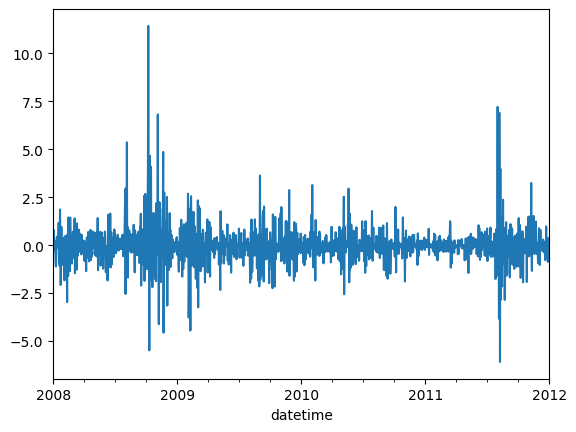

In [169]:
X_train['ts1'].plot()

<Axes: xlabel='datetime'>

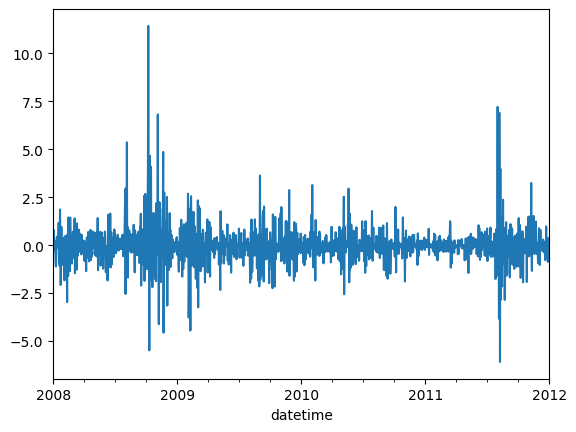

In [170]:
# X_train['ts1'].plot()
Y_train.plot()

In [88]:
from keras.preprocessing.sequence import TimeseriesGenerator
sequence_length = 3
train_generator = TimeseriesGenerator(X_train, Y_train, length=sequence_length, batch_size=1)
test_generator = TimeseriesGenerator(X_test, Y_test, length=sequence_length, batch_size=1)

In [190]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Masking
from keras.callbacks import EarlyStopping

sequence_length = 60
batch_size = 32
train_generator = TimeseriesGenerator(X_train, Y_train, length=sequence_length, batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test, Y_test, length=sequence_length, batch_size=batch_size)

input_shape=(sequence_length, X_train.shape[1])
lstm_units=[10, 10]
dropout_rate=0.5
num_epochs = 50
# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,dropout=dropout_rate, input_shape=input_shape))
model.add(Dropout(rate=0.5))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer=SGD(lr=0.0005), metrics=['mse'])

# model.add(LSTM(lstm_units[0], input_shape=input_shape, activation='tanh', recurrent_activation='sigmoid', dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True))
# model.add(Dropout(dropout_rate))
# model.add(LSTM(lstm_units[1], activation='tanh', recurrent_activation='sigmoid', dropout=dropout_rate, recurrent_dropout=dropout_rate))
# model.add(Dense(1, activation='linear'))
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
# model.add(Masking(mask_value=0., batch_input_shape=input_shape))
# model.add(
#     LSTM(100, return_sequences=True, unit_forget_bias=True, stateful=True))
# model.add(TimeDistributed(Dense(1, activation="linear")))
# model.compile(loss='mean_squared_error', optimizer=SGD(lr=0.0005), metrics=['mse'])
# Fit the model

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model.fit(train_generator, epochs=num_epochs, verbose=2,validation_data=test_generator, callbacks=[early_stopping])



# Make predictions
train_pred = model.predict(train_generator)
test_pred = model.predict(test_generator)

# Unscale the predictions and actual values
# Unscale the predictions and actual values
# Unscale the predictions and actual values
train_pred, Y_train_true = unscale_data(train_pred, Y_train[sequence_length:].to_numpy().reshape(-1, 1), scaler_Y)
test_pred, Y_test_true = unscale_data(test_pred, Y_test[sequence_length:].to_numpy().reshape(-1, 1), scaler_Y)

# Create a DataFrame of the predictions and actual values
train_results = pd.DataFrame({'Actual': Y_train_true.flatten(), 'Predicted': train_pred.flatten()}, index=train_data.index[sequence_length:])
test_results = pd.DataFrame({'Actual': Y_test_true.flatten(), 'Predicted': test_pred.flatten()}, index=test_data.index[sequence_length:])

# Evaluate the predictions
train_rmse = evaluate(Y_train_true, train_pred)
test_rmse = evaluate(Y_test_true, test_pred)

# Evaluate the model on the test set
loss, test_mape = model.evaluate(test_generator, verbose=0)
print(f"Test loss: {loss}, Test MAPE: {test_rmse}")

# Print the evaluation metrics
print("Train MSE: {:.3f}".format(train_rmse))
print("Test MSE: {:.3f}".format(test_rmse))


Epoch 1/50
44/44 - 6s - loss: 1.0244 - mse: 1.0244 - val_loss: 0.5373 - val_mse: 0.5373 - 6s/epoch - 144ms/step
Epoch 2/50
44/44 - 3s - loss: 1.0136 - mse: 1.0136 - val_loss: 0.5371 - val_mse: 0.5371 - 3s/epoch - 64ms/step
Epoch 3/50
44/44 - 3s - loss: 1.0182 - mse: 1.0182 - val_loss: 0.5370 - val_mse: 0.5370 - 3s/epoch - 64ms/step
Epoch 4/50
44/44 - 3s - loss: 1.0137 - mse: 1.0137 - val_loss: 0.5368 - val_mse: 0.5368 - 3s/epoch - 64ms/step
Epoch 5/50
44/44 - 3s - loss: 1.0204 - mse: 1.0204 - val_loss: 0.5367 - val_mse: 0.5367 - 3s/epoch - 63ms/step
Epoch 6/50
44/44 - 3s - loss: 1.0172 - mse: 1.0172 - val_loss: 0.5366 - val_mse: 0.5366 - 3s/epoch - 64ms/step
Epoch 7/50
44/44 - 3s - loss: 1.0172 - mse: 1.0172 - val_loss: 0.5366 - val_mse: 0.5366 - 3s/epoch - 65ms/step
Epoch 8/50
44/44 - 3s - loss: 1.0203 - mse: 1.0203 - val_loss: 0.5365 - val_mse: 0.5365 - 3s/epoch - 72ms/step
Epoch 9/50
44/44 - 3s - loss: 1.0118 - mse: 1.0118 - val_loss: 0.5365 - val_mse: 0.5365 - 3s/epoch - 71ms/step


AttributeError: 'numpy.ndarray' object has no attribute 'index'

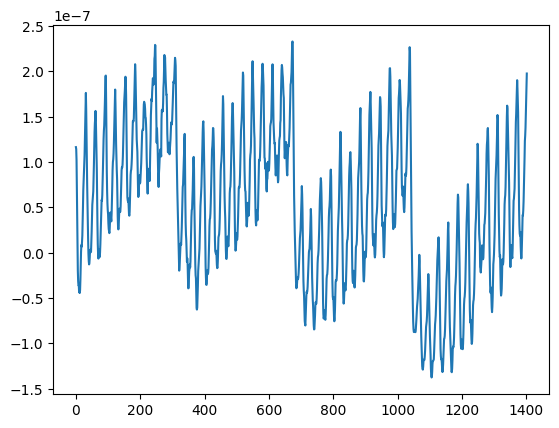

In [191]:
plt.plot(train_pred, label='Predicted')

<Axes: title={'center': 'Train Data'}, xlabel='datetime'>

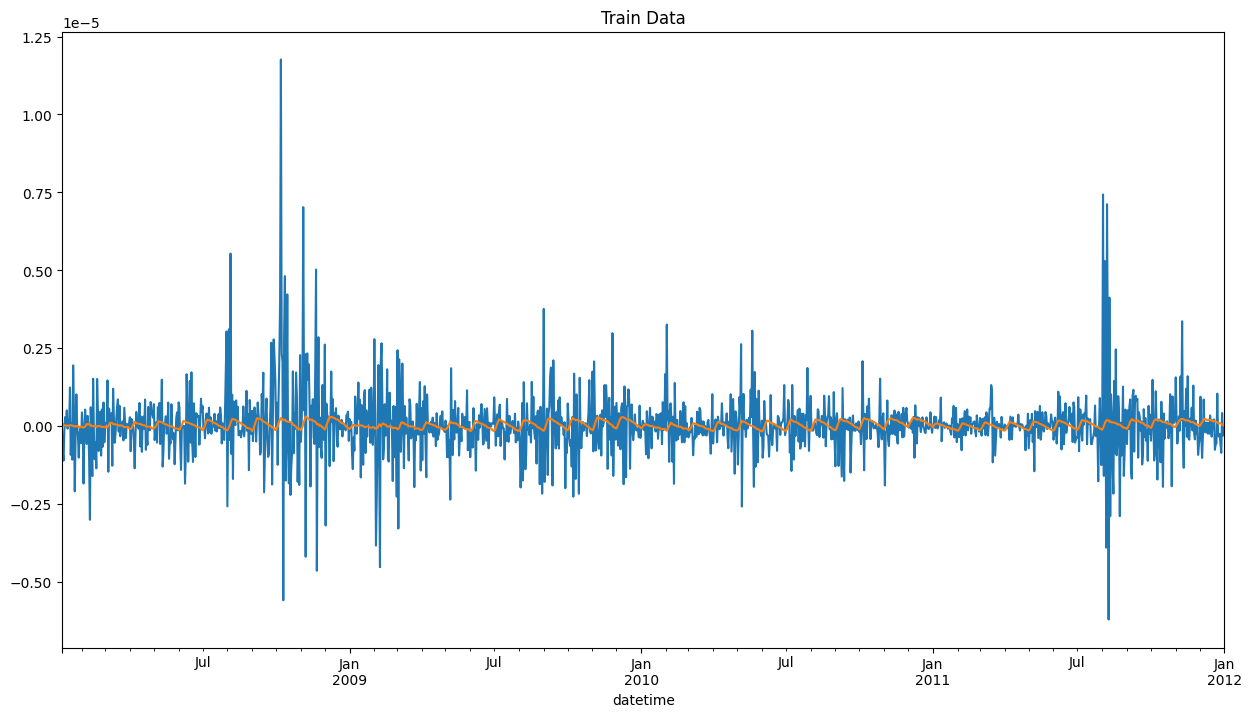

In [151]:
train_results['Actual'].plot(figsize=(15, 8), label='Actual', title='Train Data')
train_results['Predicted'].plot(figsize=(15, 8), label='Predicted')
# plot_series(series1, series2, label1="Actual", label2="Predicted", title="Unscaled Predictions vs Actual Data", save_path=None, show_plot=False)

In [178]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences.iloc[i:end_ix, :-1], sequences.iloc[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
 
# # define input sequence
# in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
# in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
# out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# # convert to [rows, columns] structure
# in_seq1 = in_seq1.reshape((len(in_seq1), 1))
# in_seq2 = in_seq2.reshape((len(in_seq2), 1))
# out_seq = out_seq.reshape((len(out_seq), 1))
# # horizontally stack columns
# dataset = hstack((in_seq1, in_seq2, out_seq))

dataset  = train_data_df
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
X, y 

(array([[[-0.28968363, -1.34005481, -1.599501  , -1.67163147],
         [ 0.80102943, -1.34005481, -1.599501  , -1.55806617],
         [ 0.25574736, -1.34005481, -1.599501  , -1.44450087]],
 
        [[ 0.80102943, -1.34005481, -1.599501  , -1.55806617],
         [ 0.25574736, -1.34005481, -1.599501  , -1.44450087],
         [ 0.40962793, -1.34005481, -1.599501  , -1.33093558]],
 
        [[ 0.25574736, -1.34005481, -1.599501  , -1.44450087],
         [ 0.40962793, -1.34005481, -1.599501  , -1.33093558],
         [-0.03601817, -1.34005481, -1.599501  , -1.21737028]],
 
        ...,
 
        [[-0.87702551,  1.33883324,  1.58840024,  1.39463157],
         [ 0.37005736,  1.33883324,  1.58840024,  1.50819687],
         [-0.34132899,  1.33883324,  1.58840024,  1.62176217]],
 
        [[ 0.37005736,  1.33883324,  1.58840024,  1.50819687],
         [-0.34132899,  1.33883324,  1.58840024,  1.62176217],
         [-0.03601817,  1.33883324,  1.58840024,  1.73532746]],
 
        [[-0.34132899,  1

In [ ]:
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
x_input = array([[80, 85], [90, 95], [100, 105]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

In [113]:

# Unscale the predictions and actual values
# Unscale the predictions and actual values
# Unscale the predictions and actual values
train_pred, Y_train_true = unscale_data(train_pred, Y_train[sequence_length:].to_numpy().reshape(-1, 1), scaler_Y)
test_pred, Y_test_true = unscale_data(test_pred, Y_test[sequence_length:].to_numpy().reshape(-1, 1), scaler_Y)

# Create a DataFrame of the predictions and actual values
train_results = pd.DataFrame({'Actual': Y_train_true.flatten(), 'Predicted': train_pred.flatten()}, index=train_data.index[sequence_length:])
test_results = pd.DataFrame({'Actual': Y_test_true.flatten(), 'Predicted': test_pred.flatten()}, index=test_data.index[sequence_length:])

# Evaluate the predictions
train_mse, train_mae, train_mape = evaluate(Y_train_true, train_pred)
test_mse, test_mae, test_mape = evaluate(Y_test_true, test_pred)

# Evaluate the model on the test set
loss, test_mape = model.evaluate(test_generator, verbose=0)
print(f"Test loss: {loss}, Test MAPE: {test_mape}")

# Print the evaluation metrics
print("Train MSE: {:.3f}, Train MAE: {:.3f}, Train MAPE: {:.3f}".format(train_mse, train_mae, train_mape))
print("Test MSE: {:.3f}, Test MAE: {:.3f}, Test MAPE: {:.3f}".format(test_mse, test_mae, test_mape))


NameError: name 'evaluate_predictions' is not defined

In [111]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

sequence_length = 3
train_generator = TimeseriesGenerator(X_train, Y_train, length=sequence_length, batch_size=1)
test_generator = TimeseriesGenerator(X_test, Y_test, length=sequence_length, batch_size=1)

lstm_units=50, look_back=1, num_epochs=10, batch_size=32, dropout_rate=0.2
# Reshape input to be [samples, time steps, features]
train_x = train_x.reshape((train_x.shape[0], look_back, 1))
test_x = test_x.reshape((test_x.shape[0], look_back, 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(8, input_shape=(look_back, 1), return_sequences=True))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mape'])

# Fit the model
model.fit(train_x, train_y, epochs=num_epochs, batch_size=batch_size, verbose=2)

# Make predictions
train_pred = model.predict(train_x)
test_pred = model.predict(test_x)

# Inverse scaling of the predictions
train_pred = scaler.inverse_transform(train_pred)
train_y = scaler.inverse_transform(train_y)
test_pred = scaler.inverse_transform(test_pred)
test_y = scaler.inverse_transform(test_y)

# Create a DataFrame of the predictions and actual values
train_results = pd.DataFrame({'Actual': train_y.flatten(), 'Predicted': train_pred.flatten()}, index=train_data.index[1:])
test_results = pd.DataFrame({'Actual': test_y.flatten(), 'Predicted': test_pred.flatten()}, index=test_data.index[1:])

# Evaluate the predictions
train_mse, train_mae, train_mape = evaluate_predictions(train_y, train_pred)
test_mse, test_mae, test_mape = evaluate_predictions(test_y, test_pred)

# Evaluate the model on the test set
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {loss}")

# Print the evaluation metrics
print("Train MSE: {:.3f}, Train MAE: {:.3f}, Train MAPE: {:.3f}".format(train_mse, train_mae, train_mape))
print("Test MSE: {:.3f}, Test MAE: {:.3f}, Test MAPE: {:.3f}".format(test_mse, test_mae, test_mape))

SyntaxError: unmatched ')' (3021771846.py, line 9)

In [13]:
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1,
)
grid_search.fit(X_train, Y_train)
best_model = grid_search.best_estimator_
cv_results = grid_search.cv_results_
mean_score = -np.mean(cv_results['mean_test_score'])
std_score = np.std(cv_results['mean_test_score'])
print("Best model:", best_model)
print("Mean error:", mean_error)
print("Standard error:", std_error)

NameError: name 'param_grid' is not defined

Epoch 1/15
44/44 [==============================] - 5s 56ms/step - loss: 1.1232
Epoch 2/15
44/44 [==============================] - 2s 55ms/step - loss: 1.1156
Epoch 3/15
44/44 [==============================] - 2s 54ms/step - loss: 1.1154
Epoch 4/15
44/44 [==============================] - 2s 49ms/step - loss: 1.1195
Epoch 5/15
44/44 [==============================] - 2s 49ms/step - loss: 1.1131
Epoch 6/15
44/44 [==============================] - 2s 49ms/step - loss: 1.1241
Epoch 7/15
44/44 [==============================] - 2s 48ms/step - loss: 1.1053
Epoch 8/15
44/44 [==============================] - 2s 50ms/step - loss: 1.1128
Epoch 9/15
44/44 [==============================] - 2s 51ms/step - loss: 1.1164
Epoch 10/15
44/44 [==============================] - 2s 52ms/step - loss: 1.1188
Epoch 11/15
44/44 [==============================] - 2s 51ms/step - loss: 1.1067
Epoch 12/15
44/44 [==============================] - 2s 52ms/step - loss: 1.1152
Epoch 13/15
44/44 [==================

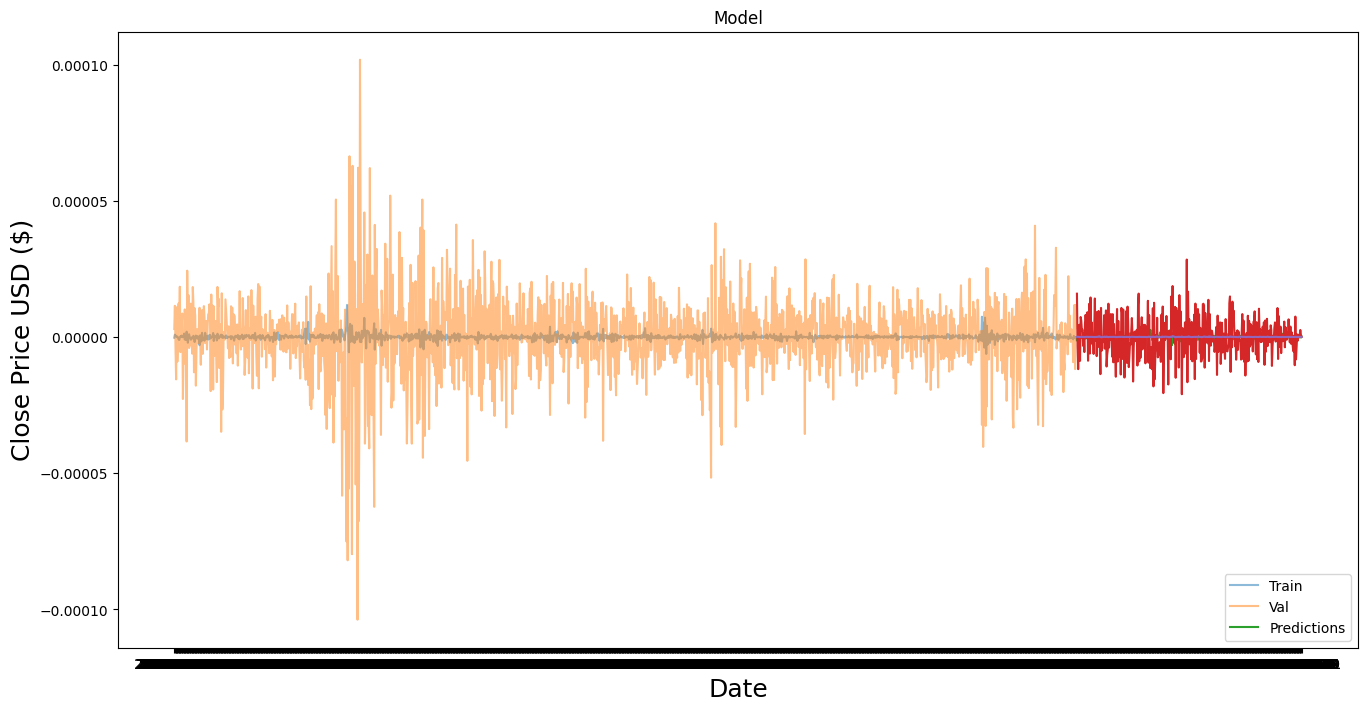

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

def create_dataset(data, window_size):
    x_data, y_data = [], []
    for i in range(window_size, len(data)):
        x_data.append(data[i-window_size:i, 0])
        y_data.append(data[i, 0])
    return np.array(x_data), np.array(y_data)

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True,dropout=dropout_rate, input_shape=input_shape))
    model.add(Dropout(rate=0.5))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_lstm_model(model, x_train, y_train, epochs=1, batch_size=1):
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
    return model

def predict_lstm_model(model, x_test, scaler):
    predictions = model.predict(x_test)
    return scaler.inverse_transform(predictions)

def evaluate_lstm_model(predictions, actual_values):
    rmse = np.sqrt(np.mean(((predictions - actual_values) ** 2)))
    return rmse

def plot_lstm_predictions(train_data, valid_data):
    plt.figure(figsize=(16, 8))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train_data, alpha=0.5)
    plt.plot(valid_data)
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

# Main script
window_size = 60
epochs = 15
batch_size = 32

# Prepare data
dataset = rt_d['ts1'].values
training_data_len = int(np.ceil(len(dataset) * 0.8))

# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset.reshape(-1, 1))
train_data = scaled_data[:training_data_len, :]
x_train, y_train = create_dataset(train_data, window_size)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build and train LSTM model
input_shape = (x_train.shape[1], 1)
model = build_lstm_model(input_shape)
model = train_lstm_model(model, x_train, y_train, epochs=epochs, batch_size=batch_size)

# Test LSTM model
test_data = scaled_data[training_data_len - window_size:, :]
x_test, y_test = create_dataset(test_data, window_size)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predictions = predict_lstm_model(model, x_test, scaler)

# Evaluate and plot results
rmse = evaluate_lstm_model(predictions, y_test)
print("Root Mean Squared Error:", rmse)

valid_data = rt_d[training_data_len:]
valid_data['Predictions'] = predictions
plot_lstm_predictions(rt_d[:training_data_len], valid_data)


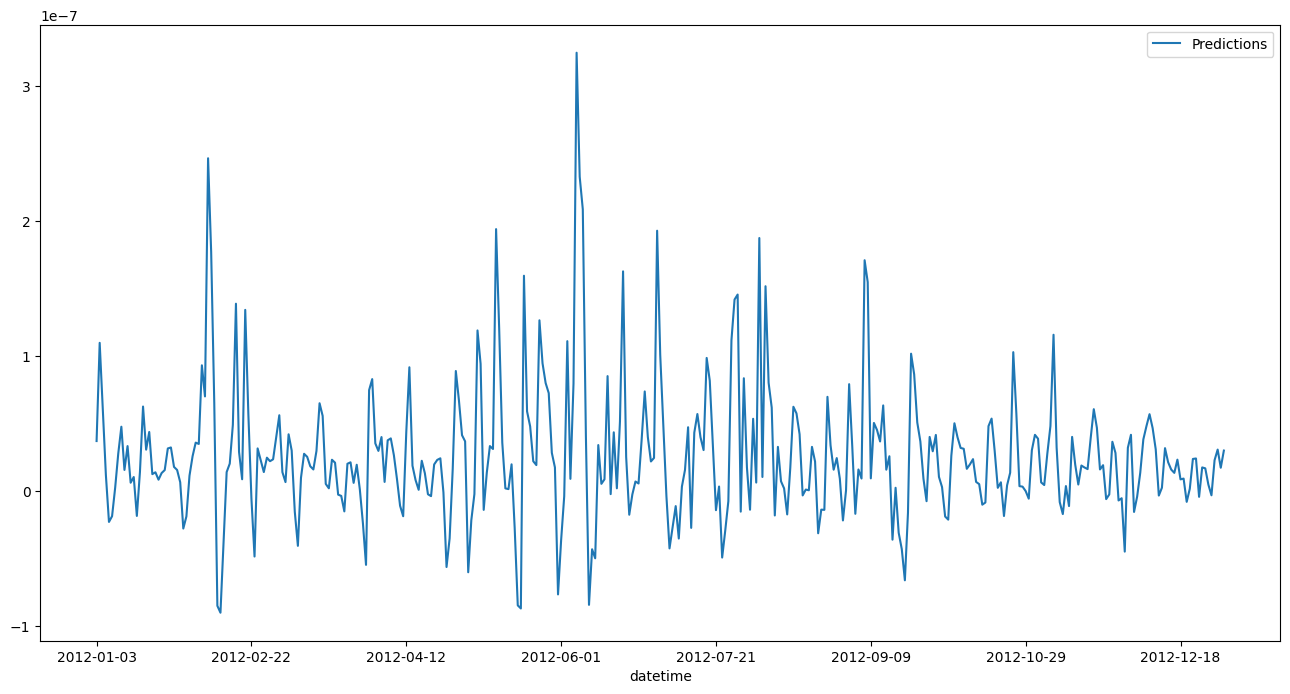

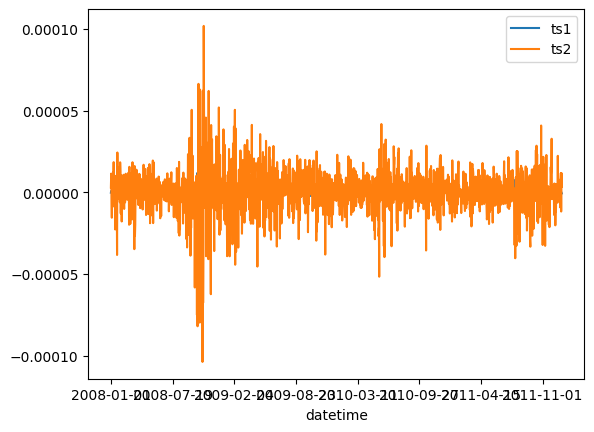

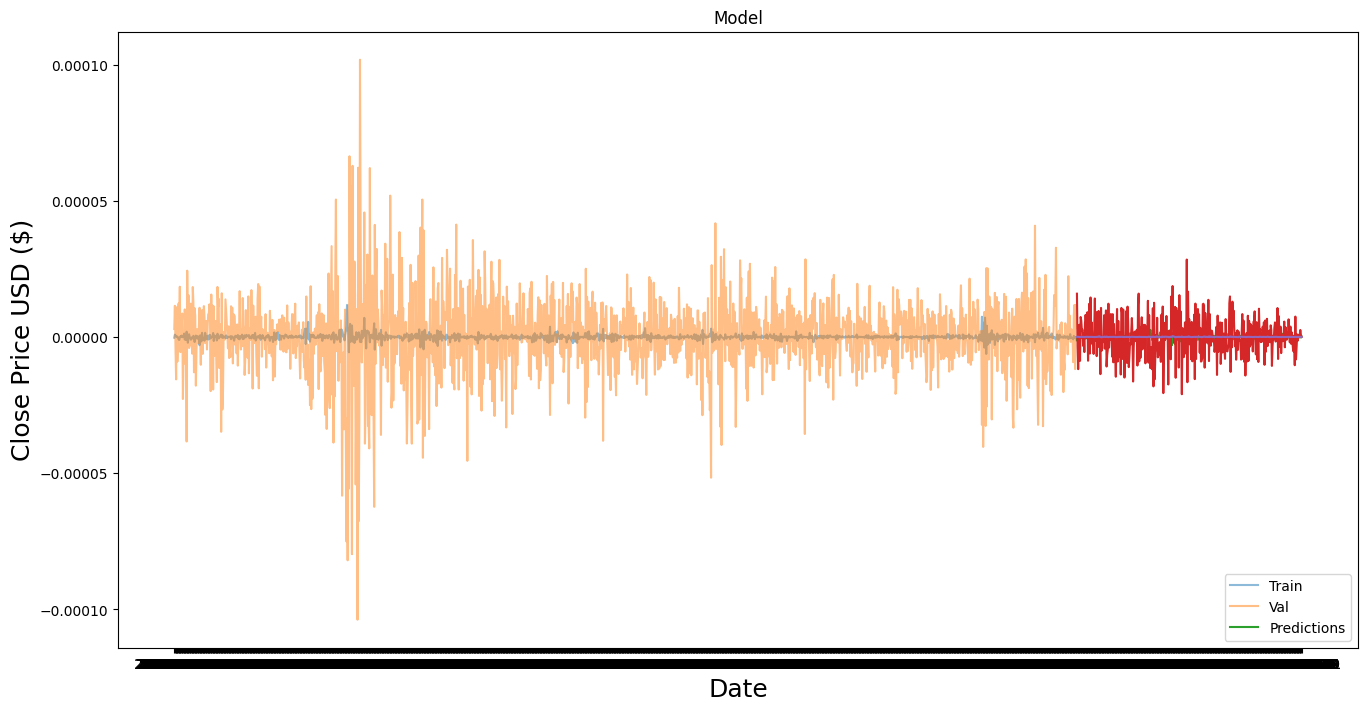

In [186]:
valid_data['Predictions'].plot(figsize=(16, 8), legend=True)
rt_d[:training_data_len].plot(legend=True)
plot_lstm_predictions(rt_d[:training_data_len], valid_data)


In [ ]:
#data geneartor
def create_dataset(dataset, look_back=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - look_back):
        data_x.append(dataset[i:(i + look_back), 0])
        data_y.append(dataset[i + look_back, 0])
    return np.array(data_x), np.array(data_y)

def data_generator(data, window_size, batch_size):
    """
    Generator function to create batches of input-output pairs for time series forecasting.
    :param data: A NumPy array containing the time series data.
    :param window_size: The size of the window used to create input-output pairs.
    :param batch_size: The number of input-output pairs per batch.
    :return: A generator that yields batches of input-output pairs.
    """
    start = 0
    while True:
        if start + batch_size >= len(data) - window_size - 1:
            start = 0

        X_batch = np.zeros((batch_size, window_size, data.shape[1]))
        y_batch = np.zeros((batch_size, 2))

        for i in range(batch_size):
            X_batch[i] = data[start:start + window_size]
            y_batch[i] = data[start + window_size, :2]
            start += 1
            
        # X_batch = np.transpose(X_batch, (0, 2, 1))
        # X_batch = np.where(np.isnan(X_batch), threshold+1, X_batch)
        
        if np.any(y_batch==mask):
            continue
        
        if np.count_nonzero(X_batch== mask)/X_batch.size > 0.5:
            continue

        yield X_batch, y_batch
        
window_size = 120  # The size of the sliding window
batch_size = 32  # The number of samples per batch

# Split the data into training and validation sets
train_split = int(0.8 * len(data))
train_data = data[:train_split]
val_split = int(0.8 * len(train_data))
val_data = train_data[val_split:]
train_data = train_data[:val_split]
test_data = data[train_split:]
print(train_data.shape, val_data.shape, test_data.shape)


# Create the training and validation generators
train_gen = data_generator(train_data, window_size, batch_size)
val_gen = data_generator(val_data, window_size, batch_size)
test_gen = data_generator(test_data, window_size, batch_size)


In [ ]:
#build gneeral


def fit_lstm(train_x, train_y, test_x, test_y, lstm_units=50, look_back=1, num_epochs=10, batch_size=32):
    # Reshape input to be [samples, time steps, features]
    train_x = train_x.reshape((train_x.shape[0], look_back, 1))
    test_x = test_x.reshape((test_x.shape[0], look_back, 1))

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(8, input_shape=(look_back, 1), return_sequences=True))
    model.add(LSTM(4))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mape'])

    # Fit the model
    model.fit(train_x, train_y, epochs=num_epochs, batch_size=batch_size, verbose=2)

    # Make predictions
    train_pred = model.predict(train_x)
    test_pred = model.predict(test_x)

    # Inverse scaling of the predictions
    train_pred = scaler.inverse_transform(train_pred)
    train_y = scaler.inverse_transform(train_y)
    test_pred = scaler.inverse_transform(test_pred)
    test_y = scaler.inverse_transform(test_y)

    # Create a DataFrame of the predictions and actual values
    train_results = pd.DataFrame({'Actual': train_y.flatten(), 'Predicted': train_pred.flatten()}, index=train_data.index[1:])
    test_results = pd.DataFrame({'Actual': test_y.flatten(), 'Predicted': test_pred.flatten()}, index=test_data.index[1:])

    # Evaluate the predictions
    train_mse, train_mae, train_mape = evaluate_predictions(train_y, train_pred)
    test_mse, test_mae, test_mape = evaluate_predictions(test_y, test_pred)
    
    # Evaluate the model on the test set
    loss = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test loss: {loss}")

    # Print the evaluation metrics
    print("Train MSE: {:.3f}, Train MAE: {:.3f}, Train MAPE: {:.3f}".format(train_mse, train_mae, train_mape))
    print("Test MSE: {:.3f}, Test MAE: {:.3f}, Test MAPE: {:.3f}".format(test_mse, test_mae, test_mape))

    return pd.concat([train_results, test_results])



def build_lstm_model(units=50, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def tune_lstm(X_train, y_train):
    param_grid = {
        'units': [50, 100],
        'activation': ['relu', 'tanh'],
        'optimizer': [Adam(learning_rate=0.001), Adam(learning_rate=0.01)]
    }
    model = KerasRegressor(build_fn=build_lstm_model, epochs=50, batch_size=32, verbose=0)
    tscv = TimeSeriesSplit(n_splits=5)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
    grid_result = grid.fit(X_train, y_train)
    best_params = grid_result.best_params_
    best_lstm_model = build_lstm_model(**best_params)
    best_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
    
    print(f"Best LSTM model with parameters {best_params}")
    return best_lstm_model

Model examples

In [ ]:
#model examples
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def get_reg_model(layer_units=[100,100],dropouts=[0.2,0.2],window_size=50):
    # build LSTM network
    model = Sequential()
    
    # hidden layer 1
    model.add(LSTM(layer_units[0], 
                   input_shape=(window_size,1), 
                   return_sequences=True))
    model.add(Dropout(dropouts[0]))
    
    # hidden layer 2
    model.add(LSTM(layer_units[1]))
    model.add(Dropout(dropouts[1]))
    
    # output layer
    model.add(Dense(1))
    model.add(Activation("linear"))
    
    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    print(model.summary())
    return model



def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model


model = Sequential()
model.add(LSTM(50, input_shape=(lookback_window, num_features), return_sequences=True))
model.add(LSTM(30, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')



from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

def create_single_layer_lstm_model(input_shape, dropout_rate=0.5, lstm_units=50):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=input_shape, activation='tanh', recurrent_activation='sigmoid', dropout=dropout_rate, recurrent_dropout=dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Usage example:
input_shape = (timesteps, num_features)
dropout_rate = 0.5
lstm_units = 50
single_layer_lstm_model = create_single_layer_lstm_model(input_shape, dropout_rate, lstm_units)


def create_stacked_lstm_model(input_shape, dropout_rate=0.5, lstm_units=[50, 50]):
    model = Sequential()
    model.add(LSTM(lstm_units[0], input_shape=input_shape, activation='tanh', recurrent_activation='sigmoid', dropout=dropout_rate, recurrent_dropout=dropout_rate, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units[1], activation='tanh', recurrent_activation='sigmoid', dropout=dropout_rate, recurrent_dropout=dropout_rate))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Usage example:
input_shape = (timesteps, num_features)
dropout_rate = 0.5
lstm_units = [50, 50]
stacked_lstm_model = create_stacked_lstm_model(input_shape, dropout_rate, lstm_units)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def create_single_layer_lstm_model(lookback_window, lstm_units, dropout_rate):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(lookback_window, 1)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def create_stacked_lstm_model(lookback_window, lstm_units_1, lstm_units_2, dropout_rate_1, dropout_rate_2):
    model = Sequential()
    model.add(LSTM(lstm_units_1, input_shape=(lookback_window, 1), return_sequences=True))
    model.add(Dropout(dropout_rate_1))
    model.add(LSTM(lstm_units_2))
    model.add(Dropout(dropout_rate_2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

#split data
#scale
#transform to supervised/sequential data generator
# reshape input train test to be [samples, time steps, features]

window_size = 120  # The size of the sliding window
batch_size = 32  # The number of samples per batch
lags = 3


X_train_LSTM, X_validation_LSTM = np.array(X_train), np.array(X_validation)
Y_train_LSTM, Y_validation_LSTM = np.array(Y_train), np.array(Y_validation)
X_train_LSTM= X_train_LSTM.reshape((X_train_LSTM.shape[0], 1, X_train_LSTM.shape[1]))
X_validation_LSTM= X_validation_LSTM.reshape((X_validation_LSTM.shape[0], 1, X_validation_LSTM.shape[1]))
print(X_train_LSTM.shape, Y_train_LSTM.shape, X_validation_LSTM.shape, Y_validation_LSTM.shape)   




x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build and train LSTM model
input_shape = (x_train.shape[1], 1)




lstm_units=50, look_back=1, num_epochs=10, batch_size=32
param_grid = {
    'units': [50, 100],
    'activation': ['relu', 'tanh'],
    'optimizer': [Adam(learning_rate=0.001), Adam(learning_rate=0.01)]
}
# evaluate parameters
neurons = [1, 5]
learn_rate = [0.001, 0.3]
momentum = [0.0, 0.9]
#Other Parameters can be modified as well
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
model = KerasRegressor(build_fn=build_lstm_model, epochs=50, batch_size=32, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_result = grid.fit(X_train, y_train)
best_params = grid_result.best_params_
best_lstm_model = build_lstm_model(**best_params)
# Fit the model
best_lstm_model.fit(train_x, train_y, epochs=num_epochs, batch_size=batch_size, verbose=2)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasRegressor

# Define the model creation function for KerasRegressor
def create_lstm_model(lookback_window=20, lstm_units=50, dropout_rate=0.2):
    # ... (same as before) ...

# Wrap the model creation function with KerasRegressor
lstm_model = KerasRegressor(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0)

# Define the parameter grid for GridSearchCV
param_grid = {
    'lookback_window': [10, 20, 30],
    'lstm_units': [30, 50, 70],
    'dropout_rate': [0.1, 0.2, 0.3],
}

# Create the TimeSeriesSplit cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=lstm_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, verbose=1)

# Prepare the input data (X, y) with the appropriate lookback window
# ... (preprocess the data as before) ...

# Fit the GridSearchCV object to the data
grid_search.fit(X, y)




In [ ]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(values)

# Define a function to create the input and output sequences for the LSTM model
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(data[i + n_steps])
    return np.array(X), np.array(y)

# Set the number of time steps for the LSTM model
n_steps = 10

# Split the data into train and test sets
train_size = int(len(scaled_values) * 0.8)
train, test = scaled_values[:train_size], scaled_values[train_size:]

# Create input and output sequences for the LSTM model
X_train, y_train = create_sequences(train, n_steps)
X_test, y_test = create_sequences(test, n_steps)

# Reshape the input data to be 3-dimensional (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

def create_dataset(data, window_size):
    x_data, y_data = [], []
    for i in range(window_size, len(data)):
        x_data.append(data[i-window_size:i, 0])
        y_data.append(data[i, 0])
    return np.array(x_data), np.array(y_data)

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def train_lstm_model(model, x_train, y_train, epochs=1, batch_size=1, verbose=2):
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

def predict_lstm_model(model, x_test, scaler):
    predictions = model.predict(x_test)
    return scaler.inverse_transform(predictions)

def evaluate_lstm_model(predictions, actual_values):
    rms = np.sqrt(np.mean(np.power((actual_values - predictions), 2)))
    return rms

def plot_lstm_predictions(train_data, valid_data, predictions):
    plt.plot(train_data)
    plt.plot(valid_data)
    plt.plot(predictions)
    plt.show()

# Main script
window_size = 60
epochs = 1
batch_size = 1
verbose = 2

# Prepare data
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])
new_data['Date'] = data['Date']
new_data['Close'] = data['Close']
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
dataset = new_data.values
train = dataset[0:987, :]
valid = dataset[987:, :]

# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
x_train, y_train = create_dataset(scaled_data[:987], window_size)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build and train LSTM model
input_shape = (x_train.shape[1], 1)
model = build_lstm_model(input_shape)
model = train_lstm_model(model, x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

# Test LSTM model
inputs = new_data[len(new_data) - len(valid) - window_size:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)
x_test, _ = create_dataset(inputs, window_size)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
closing_price = predict_lstm_model(model, x_test, scaler)

# Evaluate and plot results
rms = evaluate_lstm_model(closing_price, valid)
print("Root Mean Squared Error:", rms)

valid_df = new_data[987:]
valid_df['Predictions'] = closing_price
plot_lstm_predictions(new_data['Close'][:987], valid_df['Close'], valid_df['Predictions'])


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

def create_dataset(data, window_size):
    x_data, y_data = [], []
    for i in range(window_size, len(data)):
        x_data.append(data[i-window_size:i, 0])
        y_data.append(data[i, 0])
    return np.array(x_data), np.array(y_data)

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_lstm_model(model, x_train, y_train, epochs=1, batch_size=1):
    model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
    return model

def predict_lstm_model(model, x_test, scaler):
    predictions = model.predict(x_test)
    return scaler.inverse_transform(predictions)

def evaluate_lstm_model(predictions, actual_values):
    rmse = np.sqrt(np.mean(((predictions - actual_values) ** 2)))
    return rmse

def plot_lstm_predictions(train_data, valid_data):
    plt.figure(figsize=(16, 8))
    plt.title('Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train_data['Close'])
    plt.plot(valid_data[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.show()

# Main script
window_size = 60
epochs = 1
batch_size = 1

# Prepare data
data = df.sort_index(ascending=True, axis=0)
dataset = data['Close'].values
training_data_len = int(np.ceil(len(dataset) * 0.8))

# Preprocess data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset.reshape(-1, 1))
train_data = scaled_data[:training_data_len, :]
x_train, y_train = create_dataset(train_data, window_size)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build and train LSTM model
input_shape = (x_train.shape[1], 1)
model = build_lstm_model(input_shape)
model = train_lstm_model(model, x_train, y_train, epochs=epochs, batch_size=batch_size)

# Test LSTM model
test_data = scaled_data[training_data_len - window_size:, :]
x_test, y_test = create_dataset(test_data, window_size)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predictions = predict_lstm_model(model, x_test, scaler)

# Evaluate and plot results
rmse = evaluate_lstm_model(predictions, y_test)
print("Root Mean Squared Error:", rmse)

valid_data = data[training_data_len:]
valid_data['Predictions'] = predictions
plot_lstm_predictions(data[:training_data_len], valid_data)


In [ ]:
# Get stacked LSTM model for regression modeling
def get_reg_model(layer_units=[100,100],dropouts=[0.2,0.2],window_size=50):
    # build LSTM network
    model = Sequential()
    
    # hidden layer 1
    model.add(LSTM(layer_units[0], 
                   input_shape=(window_size,1), 
                   return_sequences=True))
    model.add(Dropout(dropouts[0]))
    
    # hidden layer 2
    model.add(LSTM(layer_units[1]))
    model.add(Dropout(dropouts[1]))
    
    # output layer
    model.add(Dense(1))
    model.add(Activation("linear"))
    
    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    print(model.summary())
    return model

# Window wise prediction function
def predict_reg_multiple(model, data, window_size=6, prediction_len=3):
    prediction_list = []
    
    # loop for every sequence in the dataset
    for window in range(int(len(data)/prediction_len)):
        _seq = data[window*prediction_len]
        predicted = []
        # loop till required prediction length is achieved
        for j in range(prediction_len):
            predicted.append(model.predict(_seq[np.newaxis,:,:])[0,0])
            _seq = _seq[1:]
            _seq = np.insert(_seq, [window_size-1], predicted[-1], axis=0)
        prediction_list.append(predicted)
    return prediction_list


# Plot window wise 
def plot_reg_results(predicted_data, true_data, prediction_len=3):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    
    # plot actual data
    ax.plot(true_data, 
            label='True Data',
            c='black',alpha=0.3)
    
    # plot flattened data
    plt.plot(np.array(predicted_data).flatten(), 
             label='Prediction_full',
             c='g',linestyle='--')
    
    #plot each window in the prediction list
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction',c='black')

    plt.title("Forecast Plot with Prediction Window={}".format(prediction_len))
    plt.show()

In [ ]:

#Running deep learning models and performing cross validation takes time
#Set the following Flag to 0 if the Deep LEarning Models Flag has to be disabled
EnableDeepLearningRegreesorFlag = 0

def create_model(neurons=12, activation='relu', learn_rate = 0.01, momentum=0):
        # create model
        model = Sequential()
        model.add(Dense(neurons, input_dim=X_train.shape[1], activation=activation))
        #The number of hidden layers can be increased
        model.add(Dense(2, activation=activation))
        # Final output layer
        model.add(Dense(1, kernel_initializer='normal'))
        # Compile model
        optimizer = SGD(lr=learn_rate, momentum=momentum)
        model.compile(loss='mean_squared_error', optimizer='adam')
        return model  
    #Add Deep Learning Regressor
if ( EnableDeepLearningRegreesorFlag == 1):
    models.append(('DNN', KerasRegressor(build_fn=create_model, epochs=100, batch_size=100, verbose=1)))  
    
X_train_LSTM, X_validation_LSTM = np.array(X_train), np.array(X_validation)
Y_train_LSTM, Y_validation_LSTM = np.array(Y_train), np.array(Y_validation)
X_train_LSTM= X_train_LSTM.reshape((X_train_LSTM.shape[0], 1, X_train_LSTM.shape[1]))
X_validation_LSTM= X_validation_LSTM.reshape((X_validation_LSTM.shape[0], 1, X_validation_LSTM.shape[1]))
print(X_train_LSTM.shape, Y_train_LSTM.shape, X_validation_LSTM.shape, Y_validation_LSTM.shape)   


def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed 9
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, validation_data=(X_validation_LSTM, Y_validatio
    
#Visual plot to check if the error is reducing
pyplot.plot(LSTMModel_fit.history['loss'], label='train')
pyplot.plot(LSTMModel_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

#Grid Search for LSTM Model

# evaluate an LSTM model for a given order (p,d,q)
def evaluate_LSTM_model(neurons=12, learn_rate = 0.01, momentum=0):
    #predicted = list()     
    LSTMModel = create_LSTMmodel(neurons, learn_rate, momentum)
    LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM,epochs=50, batch_size=72, verbose=0, shuffle=False)
    predicted = LSTMModel.predict(X_validation_LSTM)
    error = mean_squared_error(predicted, Y_validation)
    return error

# evaluate combinations of different variables of LSTM Model
def evaluate_combinations_LSTM(neurons, learn_rate, momentum): 
    best_score, best_cfg = float("inf"), None
    for n in neurons:
        for l in learn_rate:
            for m in momentum:
                combination = (n,l,m)                
                try:
                    mse = evaluate_LSTM_model(n,l,m)                    
                    if mse < best_score:
                        best_score, best_cfg = mse, combination
                    print('LSTM%s MSE=%.7f' % (combination,mse))
                except:
                    continue
    print('Best LSTM%s MSE=%.7f' % (best_cfg, best_score))
    
# evaluate parameters
neurons = [1, 5]
learn_rate = [0.001, 0.3]
momentum = [0.0, 0.9]
#Other Parameters can be modified as well
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
warnings.filterwarnings("ignore")
evaluate_combinations_LSTM(neurons,learn_rate,momentum)  


In [ ]:
import numpy as np
import pandas as pd
from math import sqrt
from numpy import mean
from numpy import array
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

def series_to_supervised(data, n_in=1, n_out=1):
    df = DataFrame(data)
    cols = list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = concat(cols, axis=1)
    agg.dropna(inplace=True)
    return agg.values

def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

def difference(data, order):
    return [data[i] - data[i - order] for i in range(order, len(data))]

def model_fit(train, config):
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_in=n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    n_features = 1
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))

    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

def model_predict(model, history, config):
    n_input, _, _, _, n_diff = config
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]

def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    train, test = data[:-n_test], data[-n_test:]
    model = model_fit(train, cfg)
    history = [x for x in train]
    for i in range(len(test)):
        yhat = model_predict(model, history, cfg)
        predictions.append(yhat)
        history.append(test[i])
    error = measure_rmse(test, predictions)
    return error

def repeat_evaluate(data, config, n_test, n_repeats=10):
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    result = mean(scores)
    return (str(config), result)

def grid_search(data, cfg_list, n_test):
    scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    scores.sort(key=lambda tup: tup[1])
    return scores

def model_configs():
    n_input = [12]
    n_nodes = [100]
    n_epochs = [50]
    n_batch = [1, 150]
    n_diff = [12]

    configs = []
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    for m in n_diff:
                        cfg = [i, j, k, l, m]
                        configs.append(cfg)
                        print('Total configs: %d' % len(configs))

    return configs

# Main function to execute grid search and display results
def main():
    series = read_csv('monthly-airline-passengers.csv', header=0, index_col=0)
    data = series.values
    n_test = 12
    cfg_list = model_configs()
    scores = grid_search(data, cfg_list, n_test)
    print('done')
    for cfg, error in scores[:3]:
        print(cfg, error)

if name == "main":
    main()

Stacked lstm

In [ ]:
# Get stacked LSTM model for regression modeling
def get_reg_model(layer_units=[100,100],dropouts=[0.2,0.2],window_size=50):
    # build LSTM network
    model = Sequential()
    
    # hidden layer 1
    model.add(LSTM(layer_units[0], 
                   input_shape=(window_size,1), 
                   return_sequences=True))
    model.add(Dropout(dropouts[0]))
    
    # hidden layer 2
    model.add(LSTM(layer_units[1]))
    model.add(Dropout(dropouts[1]))
    
    # output layer
    model.add(Dense(1))
    model.add(Activation("linear"))
    
    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print("> Compilation Time : ", time.time() - start)
    print(model.summary())
    return model

# Window wise prediction function
def predict_reg_multiple(model, data, window_size=6, prediction_len=3):
    prediction_list = []
    
    # loop for every sequence in the dataset
    for window in range(int(len(data)/prediction_len)):
        _seq = data[window*prediction_len]
        predicted = []
        # loop till required prediction length is achieved
        for j in range(prediction_len):
            predicted.append(model.predict(_seq[np.newaxis,:,:])[0,0])
            _seq = _seq[1:]
            _seq = np.insert(_seq, [window_size-1], predicted[-1], axis=0)
        prediction_list.append(predicted)
    return prediction_list


# Plot window wise 
def plot_reg_results(predicted_data, true_data, prediction_len=3):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    
    # plot actual data
    ax.plot(true_data, 
            label='True Data',
            c='black',alpha=0.3)
    
    # plot flattened data
    plt.plot(np.array(predicted_data).flatten(), 
             label='Prediction_full',
             c='g',linestyle='--')
    
    #plot each window in the prediction list
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction',c='black')

    plt.title("Forecast Plot with Prediction Window={}".format(prediction_len))
    plt.show()

In [ ]:
In [27]: import tensorflow as tf
         from keras.layers import Dense
         from keras.models import Sequential
         Using TensorFlow backend.

In [28]: np.random.seed(100)
         tf.random.set_seed(100)

In [29]: def create_model(problem='regression'):  
             model = Sequential()
             model.add(Dense(512, input_dim=len(cols),
                             activation='relu'))
             if problem == 'regression':
                 model.add(Dense(1, activation='linear'))
                 model.compile(loss='mse', optimizer='adam')
             else:
                 model.add(Dense(1, activation='sigmoid'))
                 model.compile(loss='binary_crossentropy', optimizer='adam')
             return model